Lung Cancer Gene Expression - Model Development

**Objective:** To develop and evaluate a machine learning pipeline for lung cancer classification using Random Forest. The primary goal is to maximize predictive accuracy while minimizing the number of selected genes through feature selection.

---
### Table of Contents

1.  [Data Selection for Model Development](#1.-data-for-model-development)
2.  [Row and Column Descriptions](#2.-row-and-column-description)
3.  [Data Accuracy Check](#3.-data-accuracy-check)
4.  [Data summary for training and test sets](#4.data-summary)
5.  [Log2 Transformation and Scaling](#5.-log2-scaling)
6.  [Baseline Model (Random Forest with All Features)](#6.-baseline-model)
7.  [Feature Selection (Mutual Information) and Model Optimization](#7.-feature-selection)
8.  [Pipeline](#8.-pipeline)

## 1. Data Selection for Model Development <a id='1-data-for-model-development'></a>

For this analysis, we will proceed with the x_df_raw_cleaned.csv dataset as our feature matrix, X. This dataset was selected because it retains the maximum number of original features after the initial cleaning phase, where only non-informative genes with zero variance were removed. This approach ensures that we begin our modeling process with the most comprehensive set of raw expression data.

The corresponding target variable, y, will be loaded from y_df.csv. This file contains the binary class labels (0 for Normal, 1 for Tumor) for each sample, aligned with our feature matrix.

In [2]:
import pandas as pd

# --- Load Feature Matrix (X) ---
x_file_path = 'x_df_raw_cleaned.csv'
try:
    X = pd.read_csv(x_file_path, index_col=0)
    print(f"Feature matrix 'X' loaded successfully from '{x_file_path}'.")
    print(f"X dimensions: {X.shape[0]} samples, {X.shape[1]} features")
except FileNotFoundError:
    print(f"Error: The file '{x_file_path}' was not found.")


# --- Load Target Variable (y) ---
y_file_path = 'y_df.csv'
try:
    # .squeeze("columns") converts the single-column DataFrame into a Series
    y = pd.read_csv(y_file_path, index_col=0).squeeze("columns")
    print(f"Target variable 'y' loaded successfully from '{y_file_path}'.")
    print(f"y dimensions: {y.shape[0]} labels")
    print("\nClass distribution in y:")
    print(y.value_counts())
except FileNotFoundError:
    print(f"Error: The file '{y_file_path}' was not found.")

Feature matrix 'X' loaded successfully from 'x_df_raw_cleaned.csv'.
X dimensions: 218 samples, 51208 features
Target variable 'y' loaded successfully from 'y_df.csv'.
y dimensions: 218 labels

Class distribution in y:
cancer_status
1    199
0     19
Name: count, dtype: int64


## 2. Row and Column Descriptions <a id='2-row-and-column-description'></a>

In [33]:
# Describe the feature matrix 'X'
print("--- Description of Feature Matrix (X) ---")
print("Rows (Index): Each row is a unique tissue sample from a patient.")
print("   - Index labels are sample IDs (e.g., 'L400T').")
print("Columns: Each column is a feature, representing a specific gene.")
print("   - Column labels are Ensembl Gene IDs (e.g., 'ENSG00000000003').")
print("Values: Raw gene expression counts.\\n")

# Describe the target variable 'y'
print("\nn--- Description of Target Variable (y) ---")
print("Index: Sample IDs, aligned with the rows of X.")
print("Values: Binary class labels for each sample.")
print("   - 1: Tumor sample")
print("   - 0: Normal sample")

--- Description of Feature Matrix (X) ---
Rows (Index): Each row is a unique tissue sample from a patient.
   - Index labels are sample IDs (e.g., 'L400T').
Columns: Each column is a feature, representing a specific gene.
   - Column labels are Ensembl Gene IDs (e.g., 'ENSG00000000003').
Values: Raw gene expression counts.\n

n--- Description of Target Variable (y) ---
Index: Sample IDs, aligned with the rows of X.
Values: Binary class labels for each sample.
   - 1: Tumor sample
   - 0: Normal sample


In [35]:
# --- Verify Alignment of X and y ---

# Display the head of the feature matrix X
print("--- First 5 rows of Feature Matrix (X) ---")
display(X.head())

# Display the head of the target variable y
print("\\n--- First 5 values of Target Variable (y) ---")
display(y.head())

# Programmatically check if the entire indices are identical
are_aligned = X.index.equals(y.index)

print(f"\nAre the indices of X and y perfectly aligned? -> {are_aligned}")

--- First 5 rows of Feature Matrix (X) ---


,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,...,ENSG00000272525,ENSG00000272529,ENSG00000272533,ENSG00000272536,ENSG00000272537,ENSG00000272540,ENSG00000272541,ENSG00000272542,ENSG00000272544,ENSG00000272545
L400T,6364.0,17.0,2255.0,1941.0,653.0,918.0,22449.0,2609.0,2099.0,2416.0,...,28.0,13.0,3.0,0.0,1.0,4.0,1.0,4.0,0.0,0.0
L401T,5953.0,1.0,3068.0,1317.0,1083.0,1478.0,10359.0,4318.0,2221.0,4401.0,...,19.0,18.0,19.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0
L404T,3179.0,4.0,2342.0,1931.0,1225.0,1485.0,6044.0,3406.0,4486.0,4297.0,...,6.0,15.0,16.0,0.0,1.0,11.0,2.0,2.0,0.0,0.0
L406T,3617.0,0.0,3264.0,1473.0,1101.0,1454.0,18843.0,2708.0,9493.0,4417.0,...,18.0,53.0,45.0,0.0,1.0,56.0,8.0,0.0,0.0,2.0
L413T,5363.0,131.0,2843.0,1285.0,687.0,1110.0,7972.0,3550.0,2932.0,4683.0,...,21.0,28.0,9.0,0.0,5.0,53.0,2.0,2.0,0.0,2.0


\n--- First 5 values of Target Variable (y) ---


L400T    1
L401T    1
L404T    1
L406T    1
L413T    1
Name: cancer_status, dtype: int64


Are the indices of X and y perfectly aligned? -> True


## 3. Data Accuracy Check <a id='3-data-accuracy check'></a>
Data Accuracy Check: Missing values, duplications, outliers (using univariate 
method)

Missing Values and Duplicates: 
The checks for missing values and duplicate entries (both for samples and features) were performed during the data curation phase in the previous notebook. The final datasets, X and y, have been confirmed to contain no missing values or duplicate entries.

In [45]:
# --- Verify Missing Values ---

# Check for any missing values in the feature matrix X
# .isnull() returns a boolean df, .sum() counts True values per column, the second .sum() adds them all up
missing_values_X = X.isnull().sum().sum()
print(f"Total missing values in X (features): {missing_values_X}")

# Check for any missing values in the target variable y
missing_values_y = y.isnull().sum()
print(f"Total missing values in y (target): {missing_values_y}")

Total missing values in X (features): 0
Total missing values in y (target): 0


In [49]:
# --- Verify Duplicates ---

# Check for duplicate rows (identical samples) in X
duplicate_rows = X.duplicated().sum()
print(f"Total duplicate rows (samples) in X: {duplicate_rows}")

# Check for duplicate columns (identical features/genes) in X
duplicate_columns = X.columns.duplicated().sum()
print(f"Total duplicate columns (genes) in X: {duplicate_columns}")

# Check for duplicate indices in y
# This ensures each sample ID is unique in the target variable
duplicate_indices_y = y.index.duplicated().sum()
print(f"Total duplicate indices in y: {duplicate_indices_y}")

Total duplicate rows (samples) in X: 0
Total duplicate columns (genes) in X: 0
Total duplicate indices in y: 0


In [58]:
# --- Outlier Detection using the IQR Method ---

# Select a sample gene column to analyze for outliers
# We'll use the first gene as an example
sample_gene = X.columns[0]
print(f"--- Analyzing outliers for a single gene: {sample_gene} ---")

# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = X[sample_gene].quantile(0.25)
Q3 = X[sample_gene].quantile(0.75)
IQR = Q3 - Q1

# Define the outlier boundaries
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = X[(X[sample_gene] < lower_bound) | (X[sample_gene] > upper_bound)]

print(f"Interquartile Range (IQR): {IQR:.2f}")
print(f"Lower Bound for outliers: {lower_bound:.2f}")
print(f"Upper Bound for outliers: {upper_bound:.2f}")
print(f"Number of outliers found in this gene: {len(outliers)}")

# Display the outlier samples if any are found
if not outliers.empty:
    print("\nOutlier samples found:")
    display(outliers[[sample_gene]])
else:
    print("No outliers were detected in this gene based on the IQR method.")

--- Analyzing outliers for a single gene: ENSG00000000003 ---
Interquartile Range (IQR): 2349.00
Lower Bound for outliers: -1317.00
Upper Bound for outliers: 8079.00
Number of outliers found in this gene: 10

Outlier samples found:


,ENSG00000000003
L440T,11516.0
L458T,8967.0
L481T,8602.0
L538T,8210.0
L539T,8853.0
L546T,12155.0
L601T,26379.0
L603T,11754.0
L621T,8874.0
L872T,8192.0


In [72]:
# --- Outlier Detection ---

# 1. Calculate IQR boundaries for all columns at once
Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 2. Create a boolean DataFrame of all outlier positions
# This is much faster than a loop
outliers_mask = (X < lower_bound) | (X > upper_bound)

# 3. Count outliers per gene by summing the 'True' values (which count as 1)
# and sort them to see the most problematic genes first
outlier_counts = outliers_mask.sum().sort_values(ascending=False)

# 4. Filter the series to show only genes that have at least one outlier
genes_with_outliers = outlier_counts[outlier_counts > 0]

print(f"\\nDetection complete. Found outliers in {len(genes_with_outliers)} out of {X.shape[1]} total genes.")

# 5. Display the top 10 genes with the most outliers
print("\\n--- Top 10 Genes with the Most Outliers ---")
print(genes_with_outliers.head(130))

\nDetection complete. Found outliers in 51189 out of 51208 total genes.
\n--- Top 10 Genes with the Most Outliers ---
ENSG00000244080    54
ENSG00000272057    54
ENSG00000225072    54
ENSG00000221870    54
ENSG00000233719    54
                   ..
ENSG00000212961    53
ENSG00000229088    53
ENSG00000218823    53
ENSG00000271776    53
ENSG00000179826    53
Length: 130, dtype: int64


In [86]:
# --- Verifying the Batch Effect Hypothesis ---
# After observing that many genes have the same number of outliers,
# this code checks if they are caused by the exact same set of samples.

# List of genes that have exactly 54 outliers
genes_with_54_outliers = outlier_counts[outlier_counts == 54].index.tolist()

if len(genes_with_54_outliers) > 1:
    print(f"Found {len(genes_with_54_outliers)} genes with exactly 54 outliers.")
    print("Verifying if the same samples are outliers in the first two genes of this list...")

    # 1. Select the first two genes from the list
    gene1 = genes_with_54_outliers[0]
    gene2 = genes_with_54_outliers[1]

    # 2. Get the outlier boundaries for these specific genes
    q1_g1, q3_g1 = X[gene1].quantile(0.25), X[gene1].quantile(0.75)
    iqr_g1 = q3_g1 - q1_g1
    upper_bound_g1 = q3_g1 + 1.5 * iqr_g1
    lower_bound_g1 = q1_g1 - 1.5 * iqr_g1

    q1_g2, q3_g2 = X[gene2].quantile(0.25), X[gene2].quantile(0.75)
    iqr_g2 = q3_g2 - q1_g2
    upper_bound_g2 = q3_g2 + 1.5 * iqr_g2
    lower_bound_g2 = q1_g2 - 1.5 * iqr_g2
    
    # 3. Get the sample IDs (indices) of the outliers for each gene
    outlier_samples_g1 = set(X[(X[gene1] < lower_bound_g1) | (X[gene1] > upper_bound_g1)].index)
    outlier_samples_g2 = set(X[(X[gene2] < lower_bound_g2) | (X[gene2] > upper_bound_g2)].index)

    # 4. Compare the two sets of sample IDs
    are_the_same = (outlier_samples_g1 == outlier_samples_g2)

    print(f"\\nAre the 54 outlier samples for '{gene1}' the same as for '{gene2}'? -> {are_the_same}")

    if are_the_same:
        print("\\nThis strongly suggests a 'batch effect'. The same group of 54 samples is behaving as outliers across many different genes.")
else:
    print("Not enough genes with 54 outliers were found to perform this comparison.")

Found 105 genes with exactly 54 outliers.
Verifying if the same samples are outliers in the first two genes of this list...
\nAre the 54 outlier samples for 'ENSG00000244080' the same as for 'ENSG00000272057'? -> False


In [92]:
# --- Analysis of Outlier Samples ---
# This code aggregates the outlier information by sample
# to identify which samples are the most anomalous across the entire dataset.

# 1. Sum the 'True' values horizontally (axis=1)
# This counts how many times each SAMPLE (row) is an outlier across all genes.
sample_outlier_counts = outliers_mask.sum(axis=1)

# 2. Sort the results to find which samples are most frequently outliers.
sorted_sample_counts = sample_outlier_counts.sort_values(ascending=False)

# 3. Display the top 20 samples that are most frequently outliers.
print("--- Top 20 Samples Appearing Most Frequently as Outliers ---")
print(sorted_sample_counts.head(20))

--- Top 20 Samples Appearing Most Frequently as Outliers ---
L538T         12202
L504T          8988
L563N          8629
L532N          8315
L857T          8298
L608T_2122     8281
L858T          7979
L881T          7679
L414T          7568
L658T          7533
L601T          7359
L496T          7298
L484T          7143
L545T          7139
L809T          6978
L447T          6951
L612T          6540
L834T          6301
L598T          6050
L529T          5781
dtype: int64


In [82]:
# --- Check the Class Labels of the Top Outlier Samples ---


# We use 'sorted_sample_counts' from the previous step
top_outlier_samples = sorted_sample_counts.head(20).index

# Get the corresponding labels (0 or 1) from the 'y' Series
labels_of_top_outliers = y.loc[top_outlier_samples]

print("--- Class Labels for the Top 20 Outlier Samples ---")
print(labels_of_top_outliers.value_counts())

--- Class Labels for the Top 20 Outlier Samples ---
cancer_status
1    18
0     2
Name: count, dtype: int64


In [94]:
# --- Analysis of Outlier Samples with Filter for 'Normal' ---
# After the previous analysis revealed that some of the most anomalous samples
# were unexpectedly labeled as 'Normal', this step verifies the class distribution
# within the top 20 outlier group to confirm and quantify this finding.

# 1. Your original code to get outlier counts for ALL samples
sample_outlier_counts = outliers_mask.sum(axis=1)
sorted_sample_counts = sample_outlier_counts.sort_values(ascending=False)

# 2. Filter the results to show 'Normal' (N) samples only
# .index.str.endswith('N') creates a boolean mask for the filter
is_normal_sample = sorted_sample_counts.index.str.endswith('N')
normal_sample_outliers = sorted_sample_counts[is_normal_sample]

# 3. Display the outlier counts for only the Normal samples
print("--- Outlier Counts for 'Normal' Samples Only ---")
print(normal_sample_outliers)

--- Outlier Counts for 'Normal' Samples Only ---
L563N    8629
L532N    8315
L881N    5215
L736N    3578
L738N    3341
L616N    3271
L511N    3256
L723N    3040
L809N    3036
L644N    2941
L572N    2898
L566N    2754
L661N    2629
L682N    2619
L724N    2381
L831N    2296
L561N    2230
L606N    2048
L656N    1615
dtype: int64


In [109]:
# --- Find Top 10 Outlier Genes within the NORMAL Group ---

# 1. Create a DataFrame with only 'Normal' samples (where y_cleaned == 0)
X_normal = X[y == 0]

print(f"Analyzing outliers within the {len(X_normal)} 'Normal' samples...\n")

# 2. Helper function for efficient outlier detection
def find_outlier_genes(df):
    """Finds outlier counts per gene in a given dataframe."""
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers_mask = (df < lower_bound) | (df > upper_bound)
    return outliers_mask.sum().sort_values(ascending=False)

# 3. Get the outlier counts and select the top 10 genes
normal_outlier_counts = find_outlier_genes(X_normal)
top_10_normal_genes = normal_outlier_counts.head(10).index.tolist()

print("--- Top 10 Genes with Most Outliers in NORMAL Samples ---")
print(top_10_normal_genes)

Analyzing outliers within the 19 'Normal' samples...

--- Top 10 Genes with Most Outliers in NORMAL Samples ---
['ENSG00000233041', 'ENSG00000204792', 'ENSG00000106560', 'ENSG00000258679', 'ENSG00000168256', 'ENSG00000267787', 'ENSG00000213862', 'ENSG00000125571', 'ENSG00000167695', 'ENSG00000227740']




--- Boxplots for Top Normal Outlier Genes (Compared to Tumor) ---


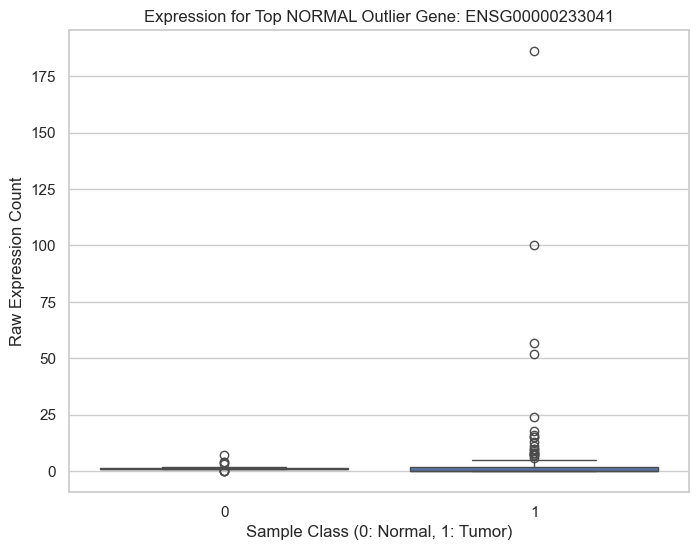

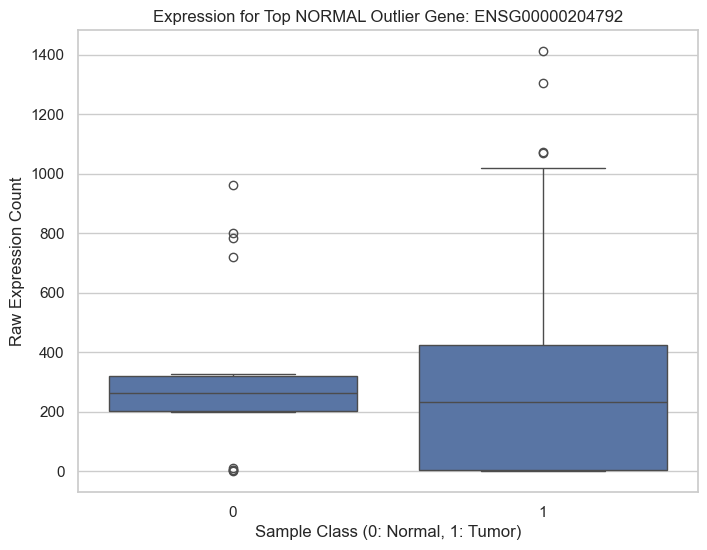

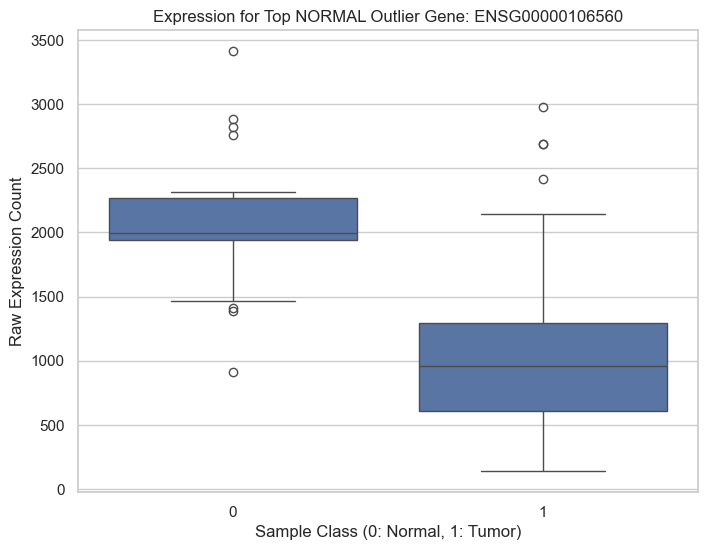

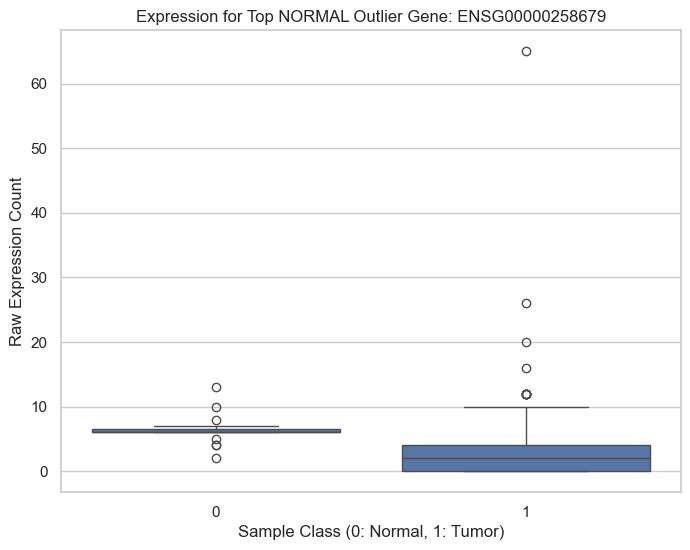

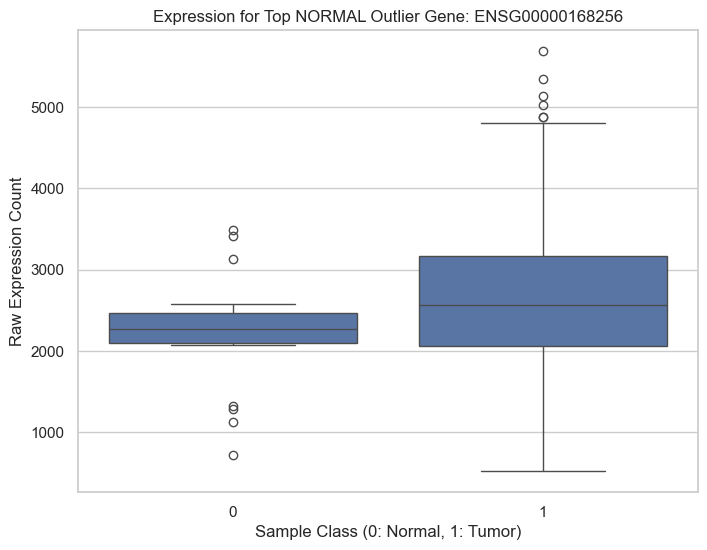

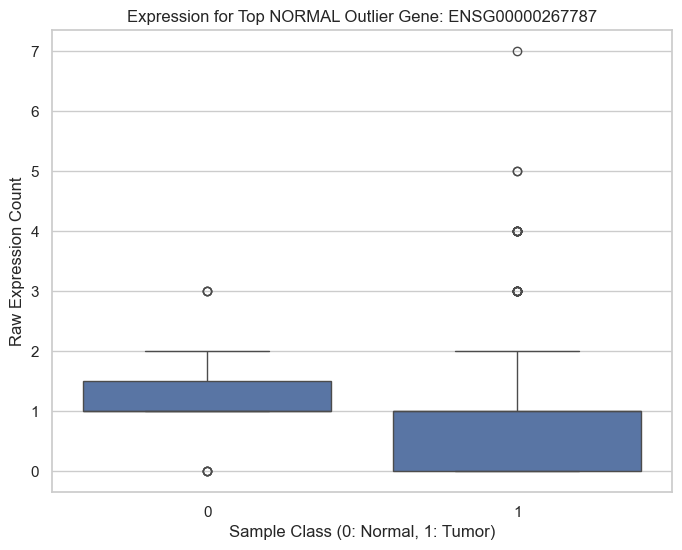

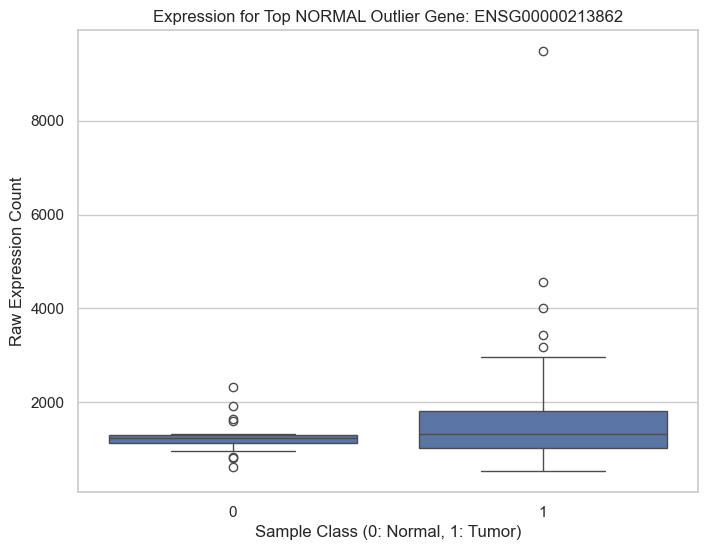

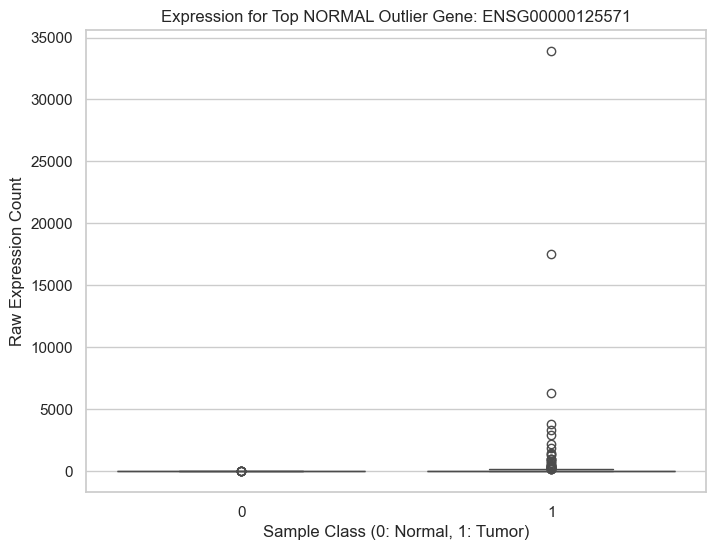

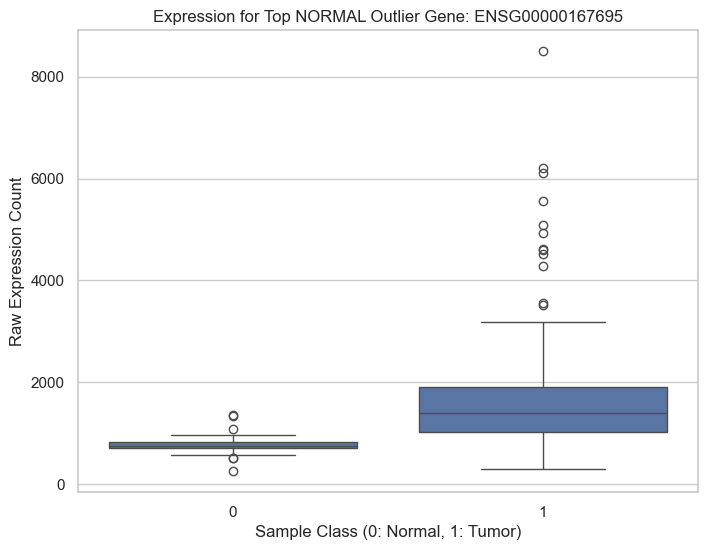

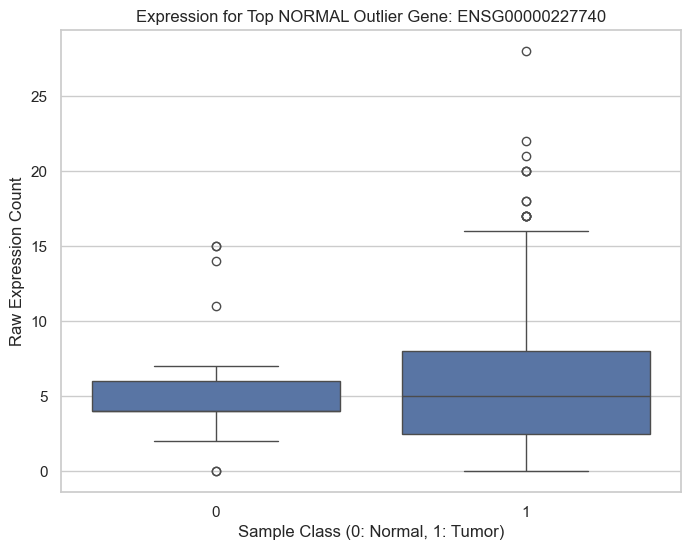

In [113]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a plotting style
sns.set_theme(style="whitegrid")

# --- Plotting Boxplots for the Top 10 Normal Outlier Genes ---
print("\n\n--- Boxplots for Top Normal Outlier Genes (Compared to Tumor) ---")

for gene in top_10_normal_genes:
    # Create a new figure for each plot
    plt.figure(figsize=(8, 6))
    
    # Create the boxplot using the full cleaned dataset for comparison
    sns.boxplot(x=y, y=X[gene])
    
    # Add titles and labels for clarity
    plt.title(f'Expression for Top NORMAL Outlier Gene: {gene}')
    plt.xlabel('Sample Class (0: Normal, 1: Tumor)')
    plt.ylabel('Raw Expression Count')
    
    # Display the plot
    plt.show()

## 4.  Data summary for training and test sets <a id='4-data-summary'></a>

In [117]:
from sklearn.model_selection import train_test_split

# --- Split Data into Training and Test Sets ---

# stratify=y ensures both sets have the same proportion of classes.
# random_state=42 ensures the split is the same every time.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [119]:
# --- Generate Data Summaries ---
print("--- Data Summary ---")

# Print the shapes of the resulting datasets
print(f"Training features (X_train) shape: {X_train.shape}")
print(f"Test features (X_test) shape:     {X_test.shape}")
print(f"Training target (y_train) shape:  {y_train.shape}")
print(f"Test target (y_test) shape:      {y_test.shape}")

# Print the class distribution for the training set
print("\n--- Class Distribution ---")
print("Training set class distribution:")
print(y_train.value_counts(normalize=True))

# Print the class distribution for the test set
print("\nTest set class distribution:")
print(y_test.value_counts(normalize=True))

--- Data Summary ---
Training features (X_train) shape: (152, 51208)
Test features (X_test) shape:     (66, 51208)
Training target (y_train) shape:  (152,)
Test target (y_test) shape:      (66,)

--- Class Distribution ---
Training set class distribution:
cancer_status
1    0.914474
0    0.085526
Name: proportion, dtype: float64

Test set class distribution:
cancer_status
1    0.909091
0    0.090909
Name: proportion, dtype: float64


## 5.  Log2 Transformation and Scaling <a id='5-log2-scaling'></a>

A two-step process is used for preprocessing:
1. Log2 Transform: np.log2(X + 1) is applied first to reduce the heavy skewness typical of raw gene count data.
2. StandardScaler: The log-transformed data is then scaled to have a mean of 0 and a standard deviation of 1 for the model.

In [134]:
import numpy as np
from sklearn.preprocessing import StandardScaler

# 1. Apply log2(x+1) transformation to the training and test sets
# We add 1 to avoid log(0)
X_train_log = np.log2(X_train + 1)
X_test_log = np.log2(X_test + 1)

# 2. Initialize the StandardScaler
scaler = StandardScaler()

# 3. Fit the scaler on the log-transformed training data and transform it
X_train_scaled = scaler.fit_transform(X_train_log)

# 4. Transform the log-transformed test data using the SAME fitted scaler
X_test_scaled = scaler.transform(X_test_log)

# 5. Convert back to DataFrames to keep column/index names
X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

print("Standard scaling applied successfully to the log-transformed data.")
display(X_train_scaled.head())

Log2 transformation applied successfully.
Standard scaling applied successfully to the log-transformed data.


,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,...,ENSG00000272525,ENSG00000272529,ENSG00000272533,ENSG00000272536,ENSG00000272537,ENSG00000272540,ENSG00000272541,ENSG00000272542,ENSG00000272544,ENSG00000272545
L863T,1.486177,-0.635779,0.667317,-0.757824,-0.161008,-1.106840,-3.265645,1.480330,-0.513675,2.423025,...,-1.680282,-1.108854,0.617560,-0.081379,-0.074368,0.508447,-1.057059,-0.883911,-0.632812,-0.257193
L642T,-0.130255,0.269199,0.013444,-0.619408,0.929250,0.005807,0.773482,0.585867,-0.246161,-0.145536,...,0.811571,0.312873,0.617560,-0.081379,-0.533955,-0.012795,-1.057059,0.552510,-0.632812,-0.257193
L723T,-0.402459,-0.635779,-0.602177,-0.888433,-0.339677,0.306908,1.278715,-0.381406,-0.888008,-0.962608,...,0.021659,-0.025755,-0.233135,-0.081379,-1.319624,0.106428,-1.057059,1.220408,1.070794,-0.257193
L818T,0.409792,-0.635779,0.917099,0.403365,1.403183,-1.975401,1.095991,-2.624077,0.117338,0.424164,...,0.021659,-1.960859,0.208202,-0.081379,1.891770,1.369034,2.530847,0.928650,1.070794,-0.257193
L829T,-0.230041,-0.635779,-0.587098,1.662815,-0.770349,-0.934431,-0.330435,-0.680032,-1.779003,0.261859,...,0.176343,-0.274855,-0.876289,-0.081379,0.711301,-0.141965,0.113530,0.928650,-0.632812,-0.257193


## 6.  [Baseline Model (Random Forest with All Features <a id='6-baseline-model'></a>

Training the baseline Random Forest model with all features...
Model training complete.

--- Baseline Model Evaluation ---
Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

  Normal (0)       1.00      1.00      1.00         6
   Tumor (1)       1.00      1.00      1.00        60

    accuracy                           1.00        66
   macro avg       1.00      1.00      1.00        66
weighted avg       1.00      1.00      1.00        66

Confusion Matrix:


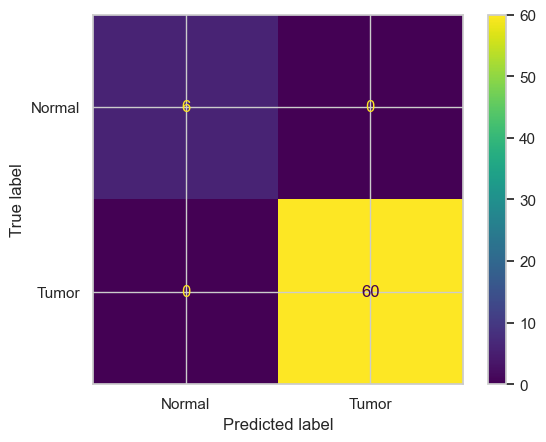

In [139]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

# --- Baseline Model Training ---

# 1. Initialize the Random Forest Classifier
# n_jobs=-1 uses all available CPU cores to speed up training.
# random_state=42 ensures reproducibility.
rf_baseline = RandomForestClassifier(n_jobs=-1, random_state=42)

print("Training the baseline Random Forest model with all features...")

# 2. Train the model on the scaled training data
rf_baseline.fit(X_train_scaled, y_train)

print("Model training complete.")

# 3. Make predictions on the scaled test set
y_pred_baseline = rf_baseline.predict(X_test_scaled)


# --- Evaluate the Baseline Model ---
print("\n--- Baseline Model Evaluation ---")

# Calculate accuracy
accuracy_baseline = accuracy_score(y_test, y_pred_baseline)
print(f"Accuracy: {accuracy_baseline:.4f}")

# Print a detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_baseline, target_names=['Normal (0)', 'Tumor (1)']))

# Display the confusion matrix
print("Confusion Matrix:")
ConfusionMatrixDisplay.from_estimator(rf_baseline, X_test_scaled, y_test, display_labels=['Normal', 'Tumor'])
plt.show()

AUC Score for the baseline model: 1.0000


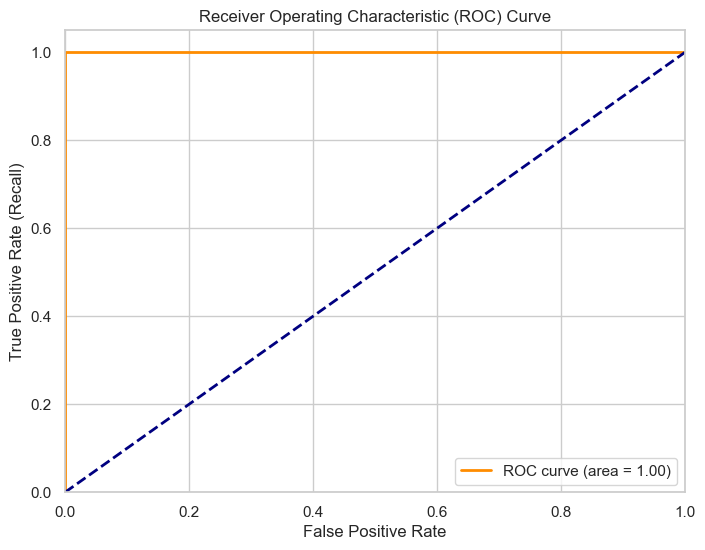

In [143]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# --- ROC Curve and AUC Score ---

# 1. Get prediction probabilities for the positive class (class 1)
# .predict_proba() returns probabilities for each class [prob_class_0, prob_class_1]
# We need the probabilities for the positive class '1' (Tumor), which is the second column [:, 1]
y_pred_proba = rf_baseline.predict_proba(X_test_scaled)[:, 1]

# 2. Calculate the AUC score
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"AUC Score for the baseline model: {auc_score:.4f}")

# 3. Calculate the points for the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# 4. Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # Dashed line for random guess
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## 7.  Feature Selection (Mutual Information) and Model Optimization <a id='7-feature-selection'></a>

In [145]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

# --- Feature Selection using Mutual Information ---

# 1. Define the number of top genes you want to select. Let's keep it at 50.
k_best_genes = 50

# 2. Initialize SelectKBest with the mutual_info_classif score function
selector = SelectKBest(score_func=mutual_info_classif, k=k_best_genes)

print("Running feature selection with Mutual Information...")

# 3. Fit the selector on the scaled training data
# This calculates the mutual information score for every gene.
selector.fit(X_train_scaled, y_train)

# 4. Get the names of the selected features
selected_features_mask = selector.get_support()
selected_features = X_train_scaled.columns[selected_features_mask]

# --- Display the Results ---
print(f"\nFeature selection complete. Selected the top {len(selected_features)} genes.")

# Get the scores and create a Series for better viewing
feature_scores = pd.Series(selector.scores_, index=X_train.columns).sort_values(ascending=False)

print("\n--- Top 10 Selected Genes and their Mutual Information Scores ---")
print(feature_scores.head(10))

Running feature selection with Mutual Information...

Feature selection complete. Selected the top 50 genes.

--- Top 10 Selected Genes and their Mutual Information Scores ---
ENSG00000161649    0.295395
ENSG00000170989    0.291009
ENSG00000150048    0.289145
ENSG00000022267    0.284368
ENSG00000185303    0.282997
ENSG00000133121    0.278428
ENSG00000102760    0.277222
ENSG00000168484    0.274828
ENSG00000139567    0.274554
ENSG00000122852    0.272797
dtype: float64


Created new datasets with only the top 50 features.
Training the new model with selected features...
Model training complete.

--- Evaluation of Model with Selected Features ---
Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

  Normal (0)       1.00      1.00      1.00         6
   Tumor (1)       1.00      1.00      1.00        60

    accuracy                           1.00        66
   macro avg       1.00      1.00      1.00        66
weighted avg       1.00      1.00      1.00        66

Confusion Matrix:


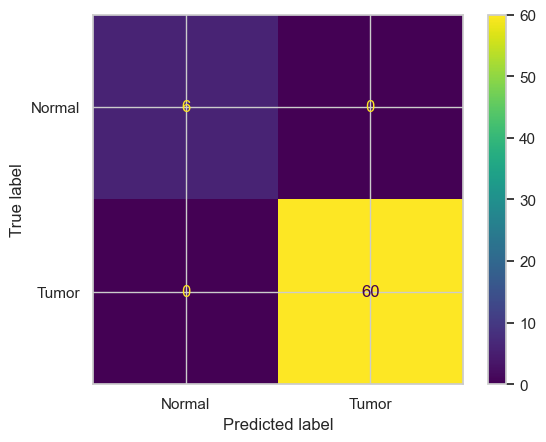

In [147]:
# --- Train and Evaluate Model with Selected Features ---

# 1. Create new training and test sets with only the selected features
# We use the 'selected_features' list from the previous step to filter the columns.
X_train_selected = X_train_scaled[selected_features]
X_test_selected = X_test_scaled[selected_features]

print(f"Created new datasets with only the top {X_train_selected.shape[1]} features.")

# 2. Initialize a new Random Forest Classifier
# We use the same parameters for a fair comparison with the baseline model.
rf_selected = RandomForestClassifier(n_jobs=-1, random_state=42)

print("Training the new model with selected features...")

# 3. Train the new model on the feature-selected training data
rf_selected.fit(X_train_selected, y_train)

print("Model training complete.")

# 4. Make predictions on the feature-selected test set
y_pred_selected = rf_selected.predict(X_test_selected)


# --- Evaluate the New Model ---
print("\n--- Evaluation of Model with Selected Features ---")

# Calculate accuracy
accuracy_selected = accuracy_score(y_test, y_pred_selected)
print(f"Accuracy: {accuracy_selected:.4f}")

# Print a detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_selected, target_names=['Normal (0)', 'Tumor (1)']))

# Display the confusion matrix
print("Confusion Matrix:")
ConfusionMatrixDisplay.from_estimator(rf_selected, X_test_selected, y_test, display_labels=['Normal', 'Tumor'])
plt.show()

--- Testing model with Top 10 Features ---
['ENSG00000161649', 'ENSG00000170989', 'ENSG00000150048', 'ENSG00000022267', 'ENSG00000185303', 'ENSG00000133121', 'ENSG00000102760', 'ENSG00000168484', 'ENSG00000139567', 'ENSG00000122852']

Created new datasets with 10 features.
Model with 10 features has been trained.

--- Evaluation of Model with 10 Features ---
Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

  Normal (0)       1.00      1.00      1.00         6
   Tumor (1)       1.00      1.00      1.00        60

    accuracy                           1.00        66
   macro avg       1.00      1.00      1.00        66
weighted avg       1.00      1.00      1.00        66

Confusion Matrix:


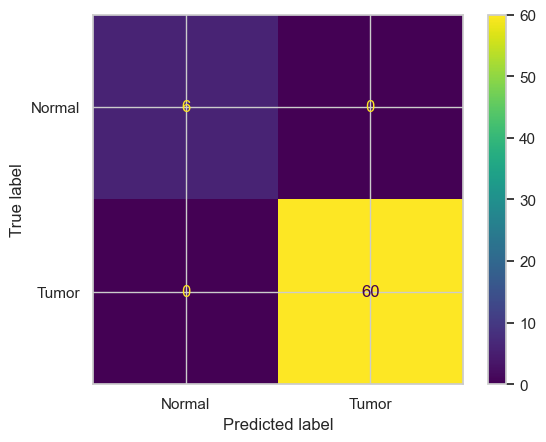

In [149]:
# --- Experiment: Model with Top 10 Features ---

# 1. Get the names of the top 10 most important genes from your previous results
# We use the 'feature_scores' Series which is already sorted.
top_10_features = feature_scores.head(10).index.tolist()

print("--- Testing model with Top 10 Features ---")
print(top_10_features)

# 2. Create new training and test sets with only these 10 features
X_train_10 = X_train_scaled[top_10_features]
X_test_10 = X_test_scaled[top_10_features]

print(f"\nCreated new datasets with {X_train_10.shape[1]} features.")

# 3. Initialize and train a new Random Forest model
rf_10_features = RandomForestClassifier(n_jobs=-1, random_state=42)
rf_10_features.fit(X_train_10, y_train)

print("Model with 10 features has been trained.")

# 4. Evaluate the model with 10 features
print("\n--- Evaluation of Model with 10 Features ---")
y_pred_10 = rf_10_features.predict(X_test_10)

# Calculate Accuracy
accuracy_10 = accuracy_score(y_test, y_pred_10)
print(f"Accuracy: {accuracy_10:.4f}")

# Print Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_10, target_names=['Normal (0)', 'Tumor (1)']))

# Display Confusion Matrix
print("Confusion Matrix:")
ConfusionMatrixDisplay.from_estimator(rf_10_features, X_test_10, y_test, display_labels=['Normal', 'Tumor'])
plt.show()

--- Testing model with Top 2 Features ---
['ENSG00000161649', 'ENSG00000170989']

Created new datasets with 2 features.
Model with 2 features has been trained.

--- Evaluation of Model with 2 Features ---
Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

  Normal (0)       1.00      1.00      1.00         6
   Tumor (1)       1.00      1.00      1.00        60

    accuracy                           1.00        66
   macro avg       1.00      1.00      1.00        66
weighted avg       1.00      1.00      1.00        66

Confusion Matrix:


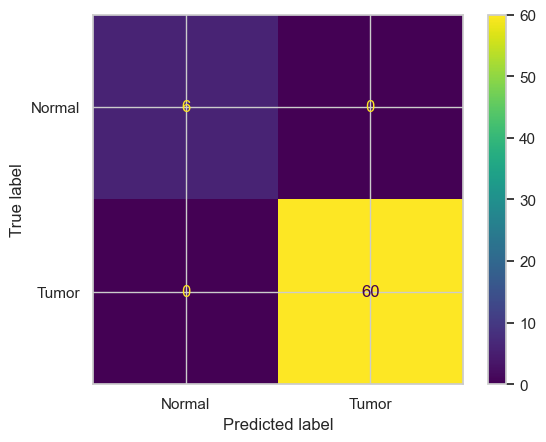

In [156]:
# --- Experiment: Model with Top 2 Features ---

# 1. Get the names of the top 2 most important genes
top_2_features = feature_scores.head(2).index.tolist()

print("--- Testing model with Top 2 Features ---")
print(top_2_features)

# 2. Create new training and test sets with only these 2 features
X_train_2 = X_train_scaled[top_2_features]
X_test_2 = X_test_scaled[top_2_features]

print(f"\nCreated new datasets with {X_train_2.shape[1]} features.")

# 3. Initialize and train a new Random Forest model
rf_2_features = RandomForestClassifier(n_jobs=-1, random_state=42)
rf_2_features.fit(X_train_2, y_train)

print("Model with 2 features has been trained.")

# 4. Evaluate the model with 2 features
print("\n--- Evaluation of Model with 2 Features ---")
y_pred_2 = rf_2_features.predict(X_test_2)

# Calculate Accuracy
accuracy_2 = accuracy_score(y_test, y_pred_2)
print(f"Accuracy: {accuracy_2:.4f}")

# Print Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_2, target_names=['Normal (0)', 'Tumor (1)']))

# Display Confusion Matrix
print("Confusion Matrix:")
ConfusionMatrixDisplay.from_estimator(rf_2_features, X_test_2, y_test, display_labels=['Normal', 'Tumor'])
plt.show()

--- Testing model with Top 1 Feature ---
['ENSG00000161649']

Created new datasets with 1 feature.
Model with 1 feature has been trained.

--- Evaluation of Model with 1 Feature ---
Accuracy: 0.9848

Classification Report:
              precision    recall  f1-score   support

  Normal (0)       1.00      0.83      0.91         6
   Tumor (1)       0.98      1.00      0.99        60

    accuracy                           0.98        66
   macro avg       0.99      0.92      0.95        66
weighted avg       0.99      0.98      0.98        66

Confusion Matrix:


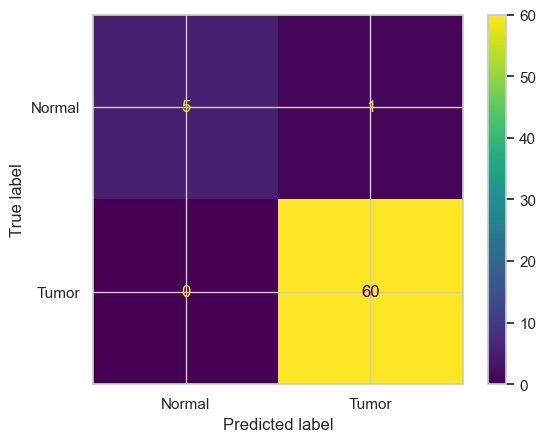

In [153]:
# --- Experiment: Model with Top 1 Feature ---

# 1. Get the name of the single most important gene
top_1_feature = feature_scores.head(1).index.tolist()

print("--- Testing model with Top 1 Feature ---")
print(top_1_feature)

# 2. Create new training and test sets with only this single feature
# Note: We use double brackets [[...]] to ensure the result is a DataFrame, not a Series.
X_train_1 = X_train_scaled[top_1_feature]
X_test_1 = X_test_scaled[top_1_feature]

print(f"\nCreated new datasets with {X_train_1.shape[1]} feature.")

# 3. Initialize and train a new Random Forest model
rf_1_feature = RandomForestClassifier(n_jobs=-1, random_state=42)
rf_1_feature.fit(X_train_1, y_train)

print("Model with 1 feature has been trained.")

# 4. Evaluate the model with 1 feature
print("\n--- Evaluation of Model with 1 Feature ---")
y_pred_1 = rf_1_feature.predict(X_test_1)

# Calculate Accuracy
accuracy_1 = accuracy_score(y_test, y_pred_1)
print(f"Accuracy: {accuracy_1:.4f}")

# Print Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_1, target_names=['Normal (0)', 'Tumor (1)']))

# Display Confusion Matrix
print("Confusion Matrix:")
ConfusionMatrixDisplay.from_estimator(rf_1_feature, X_test_1, y_test, display_labels=['Normal', 'Tumor'])
plt.show()

--- Testing model with a single feature: ENSG00000170989 ---

Created new datasets with 1 feature.
Model has been trained.

--- Evaluation of Model with feature ENSG00000170989 ---
Accuracy: 0.9848

Classification Report:
              precision    recall  f1-score   support

  Normal (0)       0.86      1.00      0.92         6
   Tumor (1)       1.00      0.98      0.99        60

    accuracy                           0.98        66
   macro avg       0.93      0.99      0.96        66
weighted avg       0.99      0.98      0.99        66

Confusion Matrix:


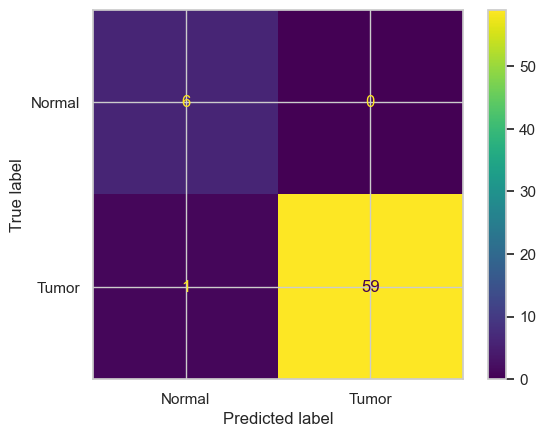

In [158]:
# --- Experiment: Model with Only the Second-Best Feature ---

# 1. Define the specific gene we want to test
# This is the second gene from your previous output.
feature_to_test = ['ENSG00000170989']

print(f"--- Testing model with a single feature: {feature_to_test[0]} ---")

# 2. Create new training and test sets with only this single feature
# We use double brackets [[...]] to keep it as a DataFrame.
X_train_single_gene = X_train_scaled[feature_to_test]
X_test_single_gene = X_test_scaled[feature_to_test]

print(f"\nCreated new datasets with 1 feature.")

# 3. Initialize and train a new Random Forest model
rf_single_gene = RandomForestClassifier(n_jobs=-1, random_state=42)
rf_single_gene.fit(X_train_single_gene, y_train)

print("Model has been trained.")

# 4. Evaluate the model
print(f"\n--- Evaluation of Model with feature {feature_to_test[0]} ---")
y_pred_single_gene = rf_single_gene.predict(X_test_single_gene)

# Calculate Accuracy
accuracy_single_gene = accuracy_score(y_test, y_pred_single_gene)
print(f"Accuracy: {accuracy_single_gene:.4f}")

# Print Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_single_gene, target_names=['Normal (0)', 'Tumor (1)']))

# Display Confusion Matrix
print("Confusion Matrix:")
ConfusionMatrixDisplay.from_estimator(rf_single_gene, X_test_single_gene, y_test, display_labels=['Normal', 'Tumor'])
plt.show()

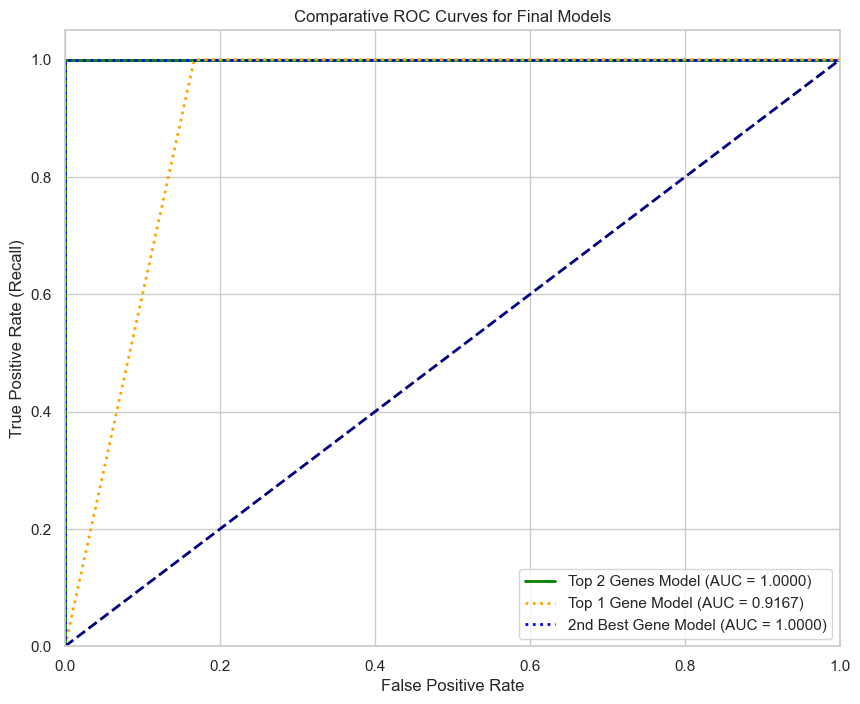

In [160]:
# --- Comparative ROC Curve Plot ---

# We need the probabilities for all three models to create the curves.
# Probabilities for the 2-feature model
y_proba_2 = rf_2_features.predict_proba(X_test_2)[:, 1]
# Probabilities for the top 1 feature model
y_proba_1 = rf_1_feature.predict_proba(X_test_1)[:, 1]
# Probabilities for the second-best feature model
y_proba_single_gene = rf_single_gene.predict_proba(X_test_single_gene)[:, 1]

# Calculate AUC scores for each
auc_2 = roc_auc_score(y_test, y_proba_2)
auc_1 = roc_auc_score(y_test, y_proba_1)
auc_single_gene = roc_auc_score(y_test, y_proba_single_gene)

# Calculate ROC curve points for each
fpr_2, tpr_2, _ = roc_curve(y_test, y_proba_2)
fpr_1, tpr_1, _ = roc_curve(y_test, y_proba_1)
fpr_single_gene, tpr_single_gene, _ = roc_curve(y_test, y_proba_single_gene)

# --- Plot all curves on a single figure ---
plt.figure(figsize=(10, 8))

# Plot the 2-feature model curve
plt.plot(fpr_2, tpr_2, color='green', lw=2, label=f'Top 2 Genes Model (AUC = {auc_2:.4f})')

# Plot the top-1-feature model curve
plt.plot(fpr_1, tpr_1, color='orange', lw=2, linestyle=':', label=f'Top 1 Gene Model (AUC = {auc_1:.4f})')

# Plot the second-best-feature model curve
plt.plot(fpr_single_gene, tpr_single_gene, color='blue', lw=2, linestyle=':', label=f'2nd Best Gene Model (AUC = {auc_single_gene:.4f})')

# Plot the random guess line
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Add labels and title
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Comparative ROC Curves for Final Models')
plt.legend(loc="lower right")
plt.show()

**Conclusion:**

A baseline Random Forest model, using all available features, established a perfect performance benchmark. To find a more efficient solution, feature selection was performed, followed by a series of experiments to determine the minimum number of genes required.

The analysis revealed that models using the top 50, 10, and even just 2 genes all successfully maintained the perfect 1.0 accuracy of the baseline model. The performance first dropped when using only the single best feature.

To investigate why the 2-gene model was perfect, the second-best feature was tested in isolation and was also found to be imperfect. This confirmed a synergy between the top two genes, where their combination is required to achieve flawless classification.

The final 2-gene model is therefore the optimal solution, as it maximize accuracy while minimizing the number of selected genes.

## 8.  Pipeline <a id='8-pipeline'></a>

This section outlines the step-by-step pipeline required to make a prediction on a new, unseen sample using the final, optimized 2-gene model. This pipeline assumes that the necessary components (the `scaler` object, the list of 2 selected features, and the trained `RandomForestClassifier` model) have been saved from the training phase and are loaded for production use.

**Pipeline Steps:**

1.  **Input:** The pipeline receives new raw gene count data for a single sample. The data must include values for the two required genes: `ENSG00000161649` and `ENSG00000170989`.

2.  **Log2 Transformation:** The raw counts of the new sample are transformed using the `log2(x + 1)` function to reduce skewness and stabilize variance.

3.  **Data Scaling:** The log-transformed data is then scaled using the **pre-fitted `StandardScaler` object** (`scaler.transform()`). It is critical that the scaler is not re-fit on the new data; it must use the parameters learned from the original training set.

4.  **Feature Selection:** From the preprocessed data, only the values for the two specific genes (`ENSG00000161649` and `ENSG00000170989`) are selected.

5.  **Prediction:** The final array, now containing only the 2 processed features, is passed to the **pre-trained 2-gene Random Forest model** (`rf_2_features.predict()`).

6.  **Output:** The model returns a single prediction: **`1`** (Tumor) or **`0`** (Normal).

**Visual Flowchart:**

[New Sample Data] -> [Log2 Transform] -> [Apply Fitted Scaler] -> [Select 2 Genes] -> [Apply Trained RF Model] -> [Prediction: 0 or 1]